## Basic image segmentation using CamVid dataset representation

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [9]:
path = Path("/storage_2/dataset_segmentation/camvid/")
path.ls()

[PosixPath('/storage_2/dataset_segmentation/camvid/valid.txt'),
 PosixPath('/storage_2/dataset_segmentation/camvid/images'),
 PosixPath('/storage_2/dataset_segmentation/camvid/labels'),
 PosixPath('/storage_2/dataset_segmentation/camvid/codes.txt')]

In [10]:
path_img = path / "images"
path_img

PosixPath('/storage_2/dataset_segmentation/camvid/images')

In [11]:
path_lbl = path / "labels"
path_lbl

PosixPath('/storage_2/dataset_segmentation/camvid/labels')

In [12]:
doc(SegmentationItemList)

## Data

In [13]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/storage_2/dataset_segmentation/camvid/images/GBM-SC1355633_02_050.png'),
 PosixPath('/storage_2/dataset_segmentation/camvid/images/MET_T100_IVONCT82468_20091013_BREBRA_007.png'),
 PosixPath('/storage_2/dataset_segmentation/camvid/images/GBM-CR680859_03_090.png')]

In [14]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/storage_2/dataset_segmentation/camvid/labels/GBM-SC1355633_02_050.png'),
 PosixPath('/storage_2/dataset_segmentation/camvid/labels/MET_T100_IVONCT82468_20091013_BREBRA_007.png'),
 PosixPath('/storage_2/dataset_segmentation/camvid/labels/GBM-CR680859_03_090.png')]

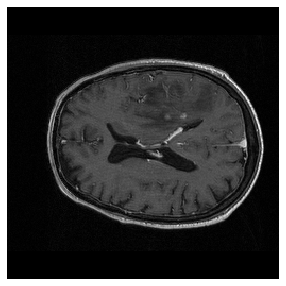

In [15]:
img_f = fnames[2]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [16]:
import re
get_y_fn = lambda x: Path(re.sub("/images/", "/labels/", str(x)))

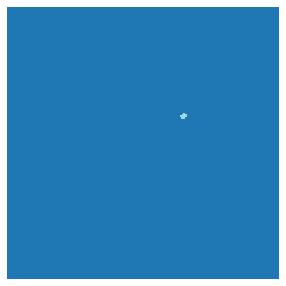

In [17]:
mask = open_mask(get_y_fn(str(img_f)))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([256, 256]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [19]:
codes = np.loadtxt(path / 'codes.txt', dtype='str'); codes

array(['HealthyTissue', 'Cancer', 'Necrosis'], dtype='<U13')

## Datasets

In [23]:
# size = src_size // 2
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 10639MB of GPU RAM free


In [24]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [22]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

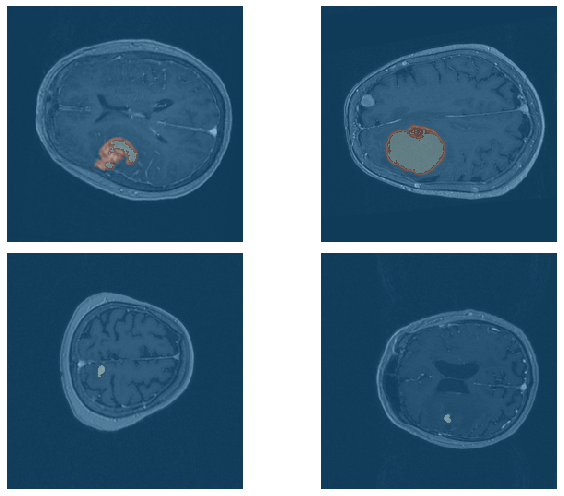

In [22]:
data.show_batch(2, figsize=(10,7))

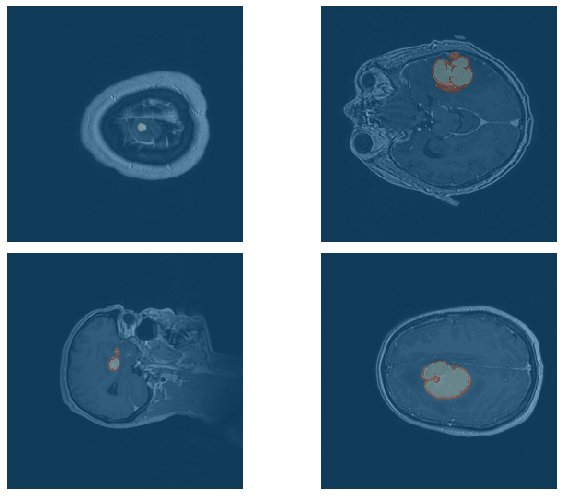

In [23]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [21]:
# metrics = accuracy

In [24]:
wd = 1e-2

In [25]:
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn = unet_learner(data, models.resnet34, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


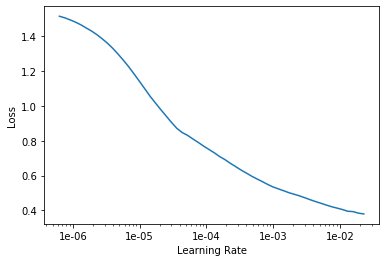

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=3e-3

In [26]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,time
0,0.009642,0.010852,06:40
1,0.008836,0.016439,06:37
2,0.009434,0.017349,06:36
3,0.008483,0.011492,06:36
4,0.007865,0.041037,06:35
5,0.008830,0.023824,06:36
6,0.008225,0.013714,06:36
7,0.008869,0.016752,06:36
8,0.007646,0.419461,06:36
9,0.006031,0.067371,06:35


In [27]:
learn.save('stage-1')

In [26]:
learn.load('stage-1');

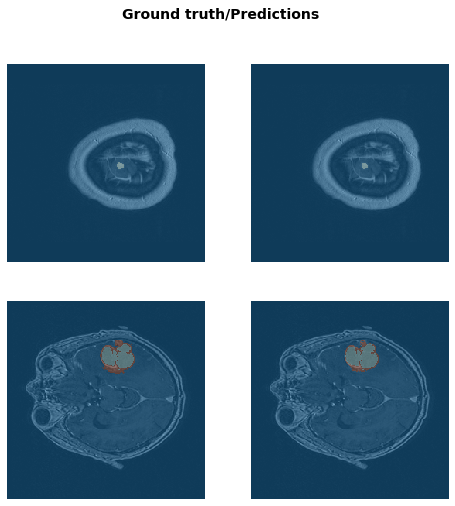

In [42]:
# learn.show_results(rows=3, figsize=(8, 9))
learn.show_results(rows=2)